In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
from scipy import stats
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('survey_results_public.csv')

In [3]:
#Quantitative variables
df.describe()

,ResponseId,CompTotal,WorkExp,ConvertedCompYearly
count,89184.000000,4.822500e+04,43579.000000,4.801900e+04
mean,44592.500000,1.036807e+42,11.405126,1.031101e+05
std,25745.347541,2.276847e+44,9.051989,6.814188e+05
min,1.000000,0.000000e+00,0.000000,1.000000e+00
25%,22296.750000,6.300000e+04,5.000000,4.390700e+04
50%,44592.500000,1.150000e+05,9.000000,7.496300e+04
75%,66888.250000,2.300000e+05,16.000000,1.216410e+05
max,89184.000000,5.000000e+46,50.000000,7.435143e+07


array([[<Axes: title={'center': 'ResponseId'}>,
        <Axes: title={'center': 'CompTotal'}>],
       [<Axes: title={'center': 'WorkExp'}>,
        <Axes: title={'center': 'ConvertedCompYearly'}>]], dtype=object)

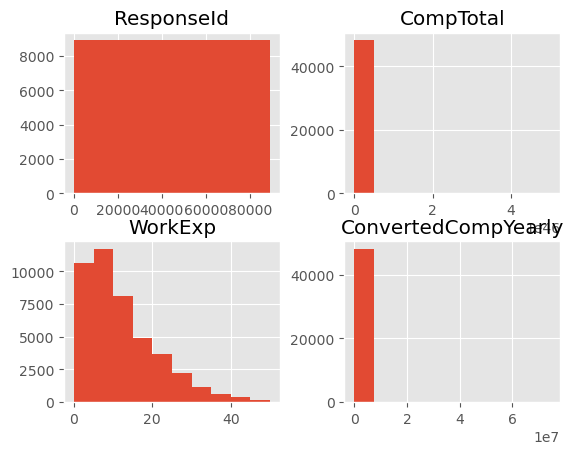

In [4]:
df.hist()

In [5]:
def create_columns_from_list_responses(df, column, pref=None, sep=';'):
    '''
    In columns for questions where respondent lists multiple items ("select all that apply"), create a column for each item with value 1 if selected, 0 if not selected

    Assumptions: If column value is NA, using False/0 for all possible items
    '''
    #split responses, extract items from each list, and remove duplicates using set
    items = set([str(item) for split in df[column].str.split(sep).dropna().values for item in split])
    #create df with columns for each possible item, and 0/1 if response contains item
    return pd.DataFrame({(pref + ' - ' if pref else '') + item : df[column].str.split(';').fillna(False).apply(lambda x : item in x if x else False) for item in items}).astype(int)

In [6]:
df.columns[df.isna().any()]

Index(['Employment', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode',
       'LearnCodeOnline', 'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro',
       'DevType', 'OrgSize', 'PurchaseInfluence', 'TechList', 'BuyNewTool',
       'Country', 'Currency', 'CompTotal', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use',
       'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
       'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith',
       'OfficeStackSyncWantToWorkWith', 'AISearchHaveWorkedWith',
       'AISearchWantToWorkWith', 'AIDevHaveWorkedWith', 'AIDevWantToW

# Languages

In [7]:
#Look at proportion of respondents who are a developer ("someone who writes code") by profession
df['MainBranch'].value_counts() / len(df)

MainBranch
I am a developer by profession                                                           0.753913
I am not primarily a developer, but I write code sometimes as part of my work/studies    0.100399
I am learning to code                                                                    0.055627
I code primarily as a hobby                                                              0.055615
I used to be a developer by profession, but no longer am                                 0.020867
None of these                                                                            0.013579
Name: count, dtype: float64

In [8]:
#Filter down to those who are developers by profession
df = df[df['MainBranch']=='I am a developer by profession']

In [9]:
#Look at missing values in languages responses
print(df['LanguageHaveWorkedWith'].isna().sum())
print(df['LanguageWantToWorkWith'].isna().sum())
print(len(df))

304
5187
67237


In [10]:
df = df.dropna(subset=['LanguageHaveWorkedWith'])

In [11]:
languages = create_columns_from_list_responses(df, 'LanguageHaveWorkedWith') #Columns for each language worked with in 2023
languages_next = create_columns_from_list_responses(df, 'LanguageWantToWorkWith') #Columns for languages to work on next year

<Axes: title={'center': 'Number of respondents who have worked with language'}>

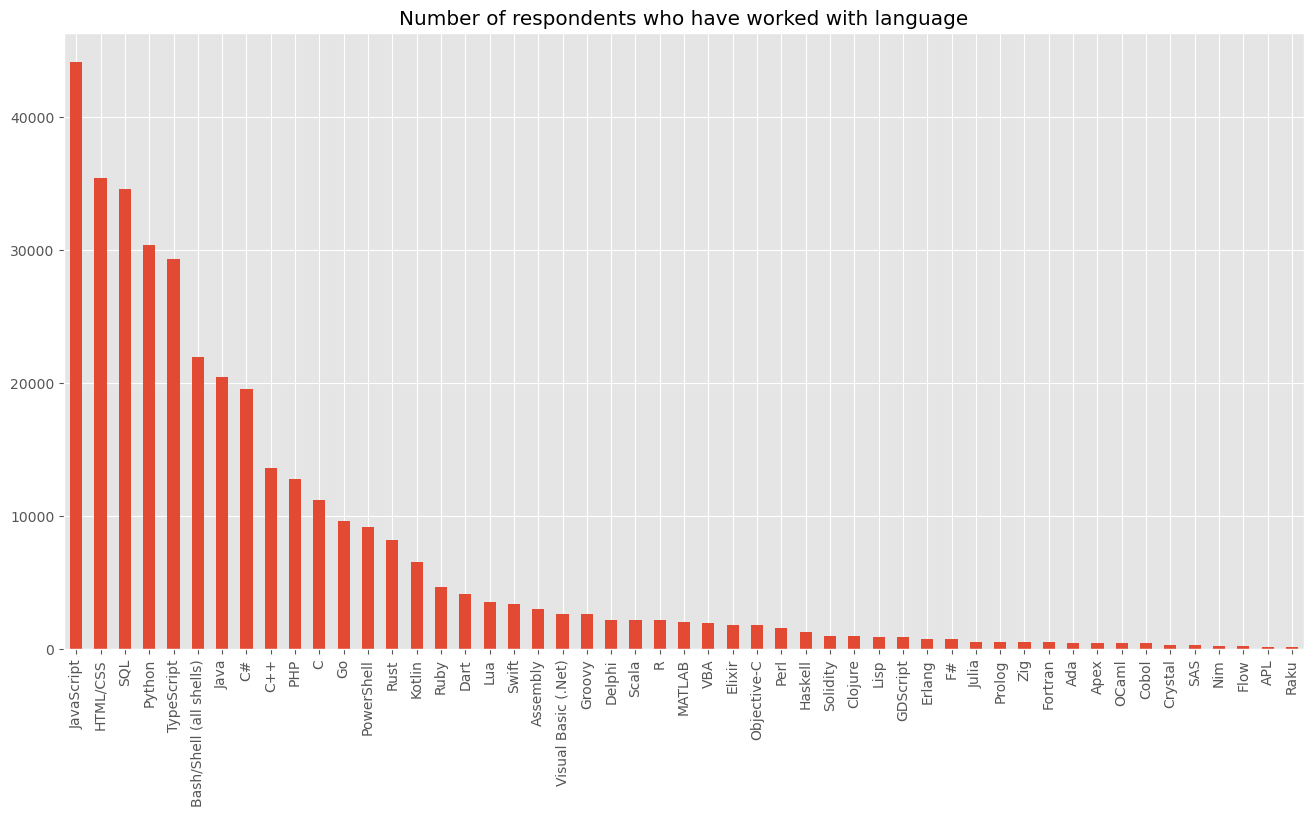

In [12]:
_, ax = plt.subplots(figsize=(16,8))
languages.sum().sort_values(ascending=False).plot.bar(title='Number of respondents who have worked with language')

## Languages and Salary

In [13]:
df_languages_salary = pd.concat([df[['Currency', 'ConvertedCompYearly', 'CompTotal']], languages], axis='columns')
print(f'{len(df_languages_salary)} total records \nNumber of non-NA records:')
print((~df_languages_salary[['Currency', 'CompTotal', 'ConvertedCompYearly']].isna()).sum())

66933 total records 
Number of non-NA records:
Currency               59306
CompTotal              44420
ConvertedCompYearly    44245
dtype: int64


<Axes: title={'center': 'Proportion of non-missing converted salary entries per language'}>

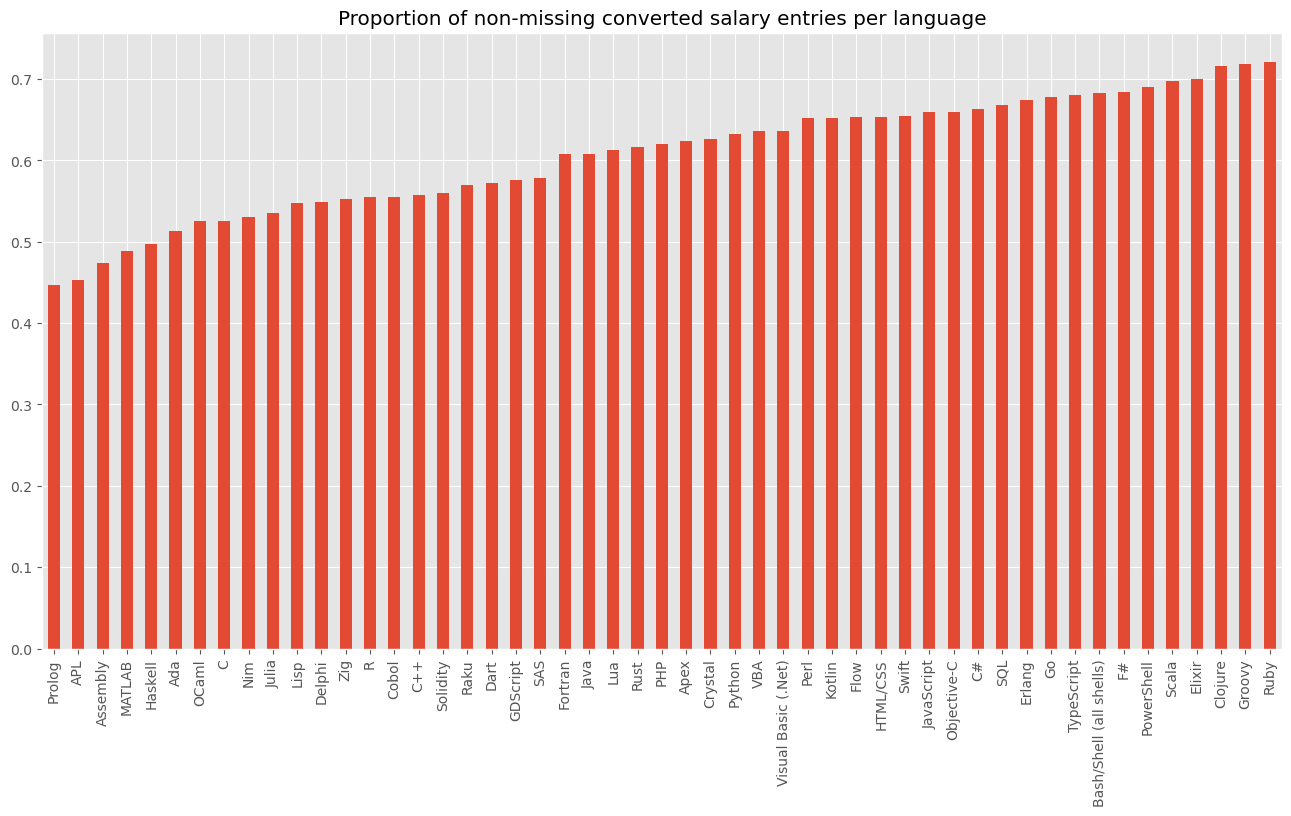

In [14]:
_, ax = plt.subplots(figsize=(16,8))
pd.Series({language : (~df_languages_salary[df_languages_salary[language]==1]['ConvertedCompYearly'].isna()).mean() for language in languages}).sort_values().plot.bar(ax=ax, title='Proportion of non-missing converted salary entries per language')

### Compare Salaries by Language Usage

Outlier analysis and removal

In [15]:
df_languages_salary = df_languages_salary[~df_languages_salary['ConvertedCompYearly'].isna()]

<Axes: >

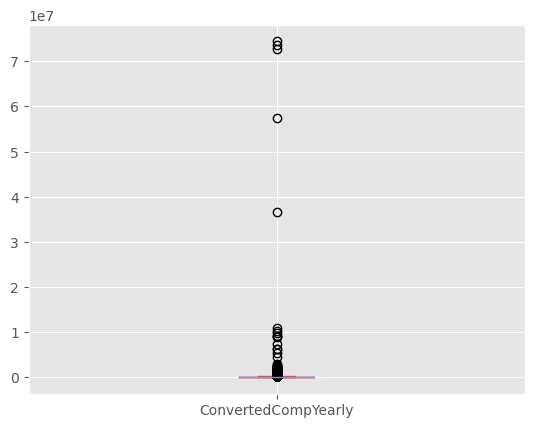

In [16]:
df_languages_salary['ConvertedCompYearly'].plot.box() #shows many outliers!

In [17]:
print('Mean - Median:' + str(df_languages_salary['ConvertedCompYearly'].mean()-df_languages_salary['ConvertedCompYearly'].median())) #look at the difference between mean and median!
print('Range: ' + str(df_languages_salary['ConvertedCompYearly'].max() - df_languages_salary['ConvertedCompYearly'].min()))

Mean - Median:28659.073002599165
Range: 74351431.0


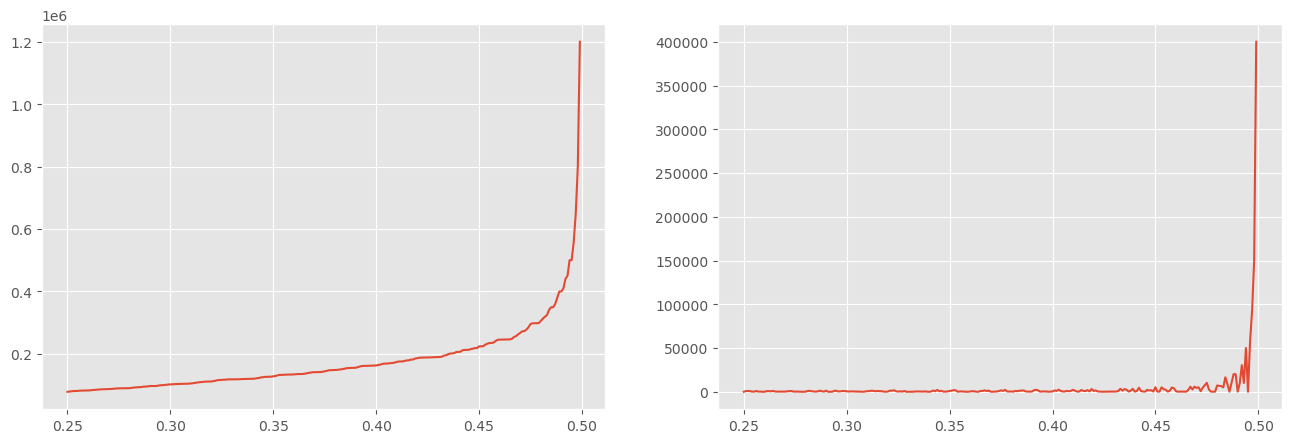

In [18]:
quantile_ranges = []
quantile_ranges_dx = []
for quantile_step in np.arange(0.25, 0.5, 0.001):
    quantiles = df_languages_salary['ConvertedCompYearly'].quantile(q=[0.5-quantile_step, 0.5+quantile_step])
    quantile_ranges_dx.append(quantiles.iat[1] - quantiles.iat[0] - quantile_ranges[-1] if quantile_ranges else 0)
    quantile_ranges.append(quantiles.iat[1] - quantiles.iat[0])    

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))
ax1.plot(np.arange(0.25, 0.5, 0.001), quantile_ranges)
ax2.plot(np.arange(0.25, 0.5, 0.001), quantile_ranges_dx)

In [19]:
#Function to remove outliers in column from df using quantiles and z-score/std deviations
def remove_outliers(df, column, inner_quantile=0.999, std_dev=3):
    quantiles = df[column].quantile(q=[.5-inner_quantile/2, .5+inner_quantile/2])
    new_df = df[(df[column] >  quantiles.iat[0]) & (df[column] < quantiles.iat[1])] #quantile-based outlier removal
    new_df = new_df[np.abs(stats.zscore(new_df[column])) < std_dev] #z-score/std dev based outlier removal
    return new_df

In [20]:
#Remove outliers and recheck mean vs median and range of dataset
df_languages_salary_filtered = remove_outliers(df_languages_salary, 'ConvertedCompYearly')
print('Mean - Median:' + str(df_languages_salary_filtered['ConvertedCompYearly'].mean()-df_languages_salary_filtered['ConvertedCompYearly'].median()))
print('Range: ' + str(df_languages_salary_filtered['ConvertedCompYearly'].max() - df_languages_salary_filtered['ConvertedCompYearly'].min()))

Mean - Median:13241.613951036124
Range: 355390.0


Salary analysis
- For each language:
  - Split data into those who have worked with the language $P_1$ and those who have not $P_2$
  - Calculate the mean salary in USD (using `ConvertedCompYearly` column) for each group ($\bar{x}_1$ and $\bar{x}_2$)
  - Calculate the difference in means ($\bar{x}_1-\bar{x}_2$)

In [21]:
language_salary_comparison = {'used_avg_salary': [], 'not_used_avg_salary' : []}
for language in languages.sum().sort_values().index: #order languages by popularity for visualizations
    language_salary_comparison['used_avg_salary'].append(df_languages_salary_filtered[df_languages_salary_filtered[language]==1]['ConvertedCompYearly'].mean())
    language_salary_comparison['not_used_avg_salary'].append(df_languages_salary_filtered[df_languages_salary_filtered[language]==0]['ConvertedCompYearly'].mean())
language_salary_comparison = pd.DataFrame(language_salary_comparison, index=languages.sum().sort_values().index)
language_salary_comparison['salary_difference'] = language_salary_comparison['used_avg_salary'] - language_salary_comparison['not_used_avg_salary']

<Axes: title={'center': 'Difference in mean salary (USD) of language users vs non-users'}>

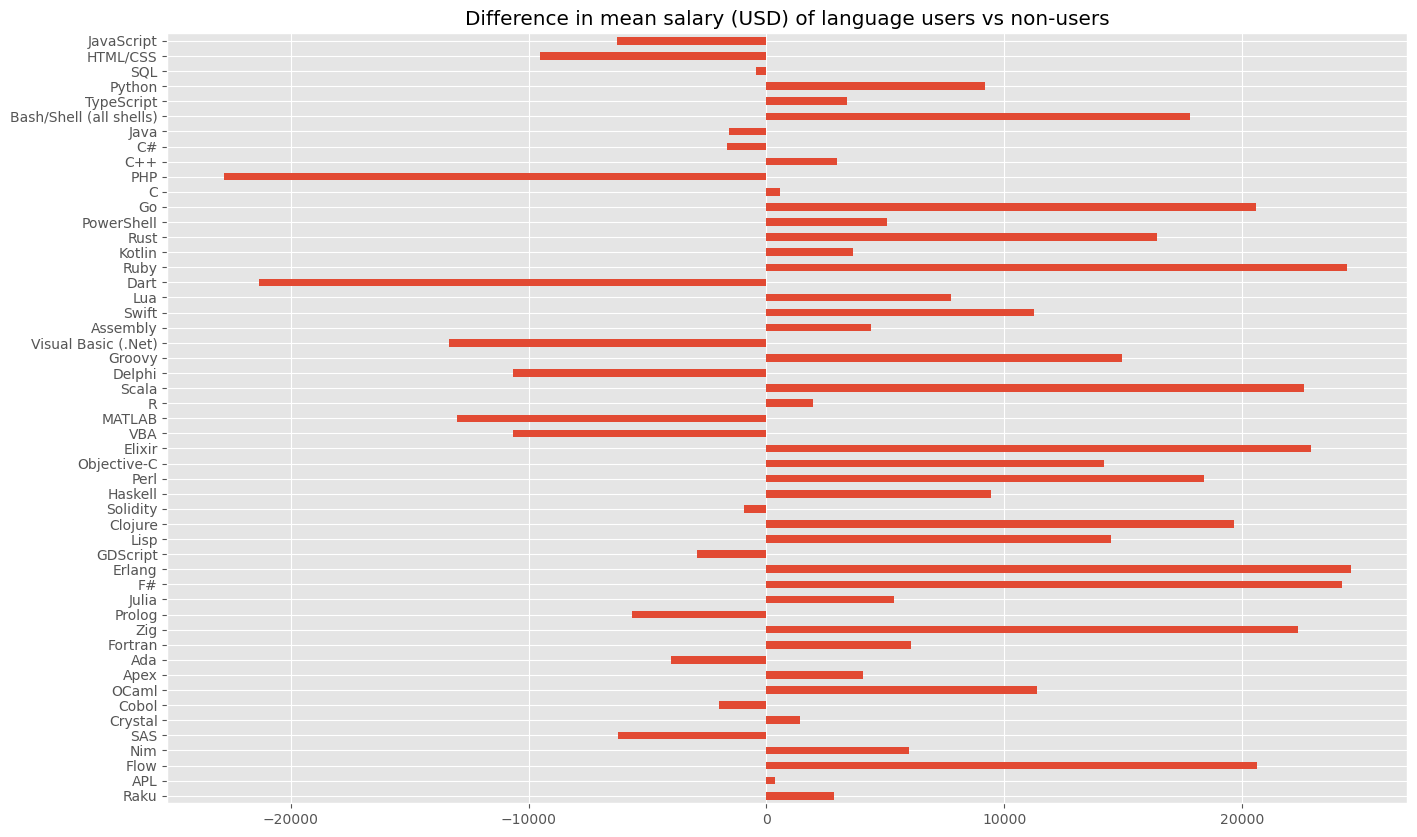

In [22]:
_, ax = plt.subplots(figsize=(16, 10))
language_salary_comparison['salary_difference'].plot.barh(ax=ax, title='Difference in mean salary (USD) of language users vs non-users')

<Axes: title={'center': 'Mean salary (USD) of language users'}>

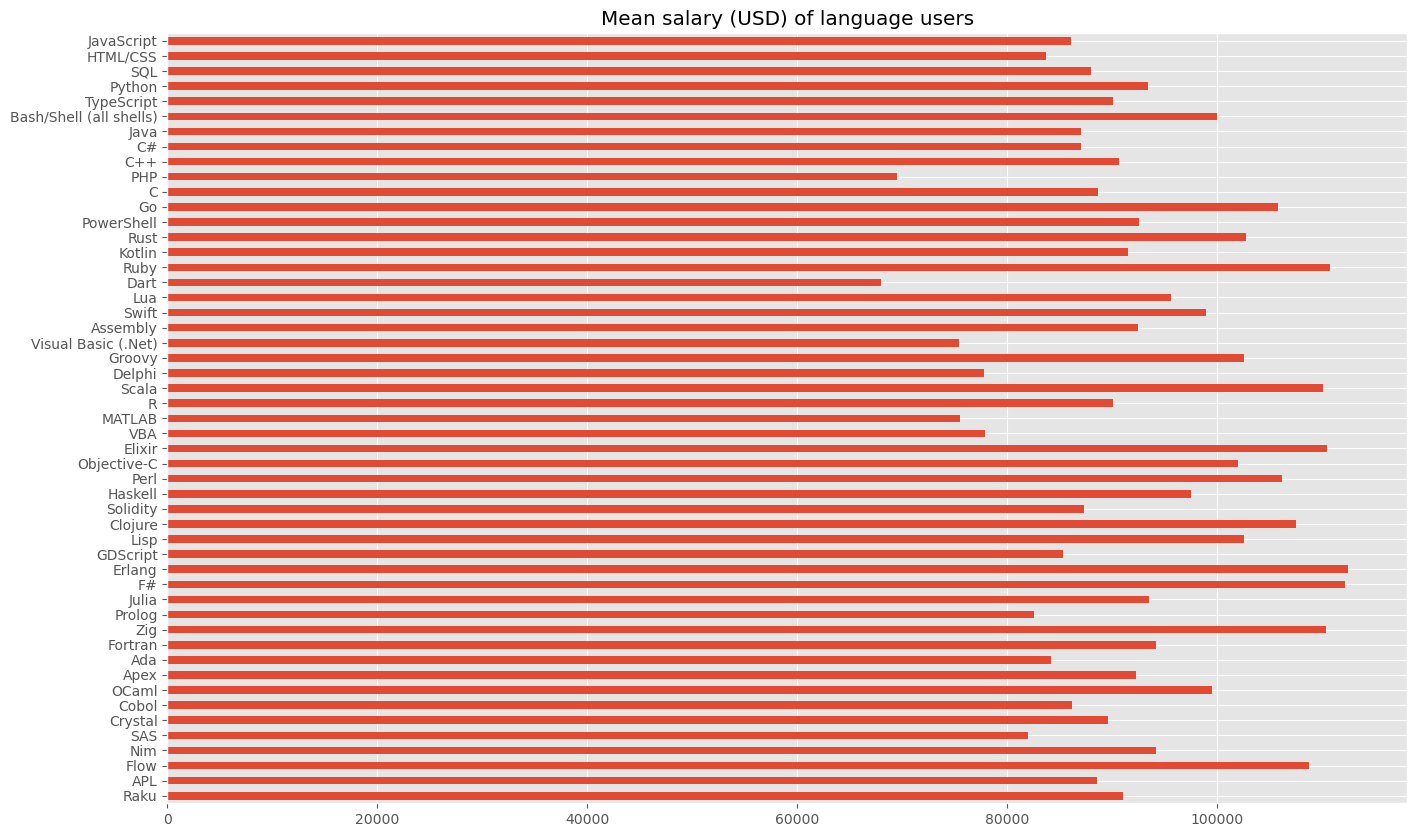

In [23]:
_, ax = plt.subplots(figsize=(16, 10))
language_salary_comparison['used_avg_salary'].plot.barh(ax=ax, title='Mean salary (USD) of language users')

## Languages by industry

In [24]:
df['Industry'].value_counts()

Industry
Information Services, IT, Software Development, or other Technology    16931
Financial Services                                                      4128
Other                                                                   3570
Manufacturing, Transportation, or Supply Chain                          2314
Healthcare                                                              2031
Retail and Consumer Services                                            1813
Higher Education                                                         838
Advertising Services                                                     746
Insurance                                                                659
Oil & Gas                                                                238
Legal Services                                                           197
Wholesale                                                                168
Name: count, dtype: int64

In [25]:
df_languages_by_industry = pd.concat([df[['Industry']], languages], axis='columns') #attach language encoding

#only look at those who code as part of their profession/studies
df_languages_by_industry = df_languages_by_industry.dropna() #drop records with missing industry entry
#df_languages_by_industry = df_languages_by_industry[df_languages_by_industry['Industry']!='Other'] #Remove other category

In [26]:
df_languages_by_industry['Industry'].value_counts()

Industry
Information Services, IT, Software Development, or other Technology    16931
Financial Services                                                      4128
Other                                                                   3570
Manufacturing, Transportation, or Supply Chain                          2314
Healthcare                                                              2031
Retail and Consumer Services                                            1813
Higher Education                                                         838
Advertising Services                                                     746
Insurance                                                                659
Oil & Gas                                                                238
Legal Services                                                           197
Wholesale                                                                168
Name: count, dtype: int64

#### Statistical Tests for Proportions (Language Usage)

In [27]:
df_languages_by_industry.groupby('Industry').count().iloc[:,0]

Industry
Advertising Services                                                     746
Financial Services                                                      4128
Healthcare                                                              2031
Higher Education                                                         838
Information Services, IT, Software Development, or other Technology    16931
Insurance                                                                659
Legal Services                                                           197
Manufacturing, Transportation, or Supply Chain                          2314
Oil & Gas                                                                238
Other                                                                   3570
Retail and Consumer Services                                            1813
Wholesale                                                                168
Name: MATLAB, dtype: int64

- For each language $l$
  - For each language $i$
    - Perform z-test between two proportions with alternative hypothesis $p_1 > p_2$:
      - $p_1 =$ proportion of people using language $l$ in industry $i$
      - $p_2 =$ proportion of people using language $l$ in all industries other than $i$

In [28]:
counts = df_languages_by_industry.groupby('Industry').sum() #get num of successes (language used) for each language, grouped by industry
nobss = df_languages_by_industry.groupby('Industry').count().iloc[:, 0] #get total num of observations for each industry
prop_tests = {}
z_tests = {}
prop_diffs = {}
for language in languages.sum().sort_values(ascending=False).index: #sort by most popular overall language for visualization purposes
    prop_tests[language] = []
    z_tests[language] = []
    prop_diffs[language] = []
    for industry in nobss.index:
        #perform two proportion z-test and store z-scores and p values
        count = [counts.at[industry, language], counts[language].sum() - counts.at[industry, language]] #number of successes for each group
        nobs = [nobss[industry], nobss.sum() - nobss[industry]] #number of observations for each group
        z, p = proportions_ztest(count, nobs, alternative='larger')
        z_tests[language].append(z)
        prop_tests[language].append(p)
        prop_diffs[language].append((count[0]/nobs[0]) - (count[1]/nobs[1]))

#dataframes storing p values and z scores, where column = language and index = industry
prop_tests = pd.DataFrame(prop_tests, index=nobss.index)
z_tests = pd.DataFrame(z_tests, index=nobss.index)
prop_diffs = pd.DataFrame(prop_diffs, index=nobss.index)

<Axes: title={'center': 'Probability of larger share of language usage within an industry vs others (1-p), salmon pink: p < 0.05'}, ylabel='Industry'>

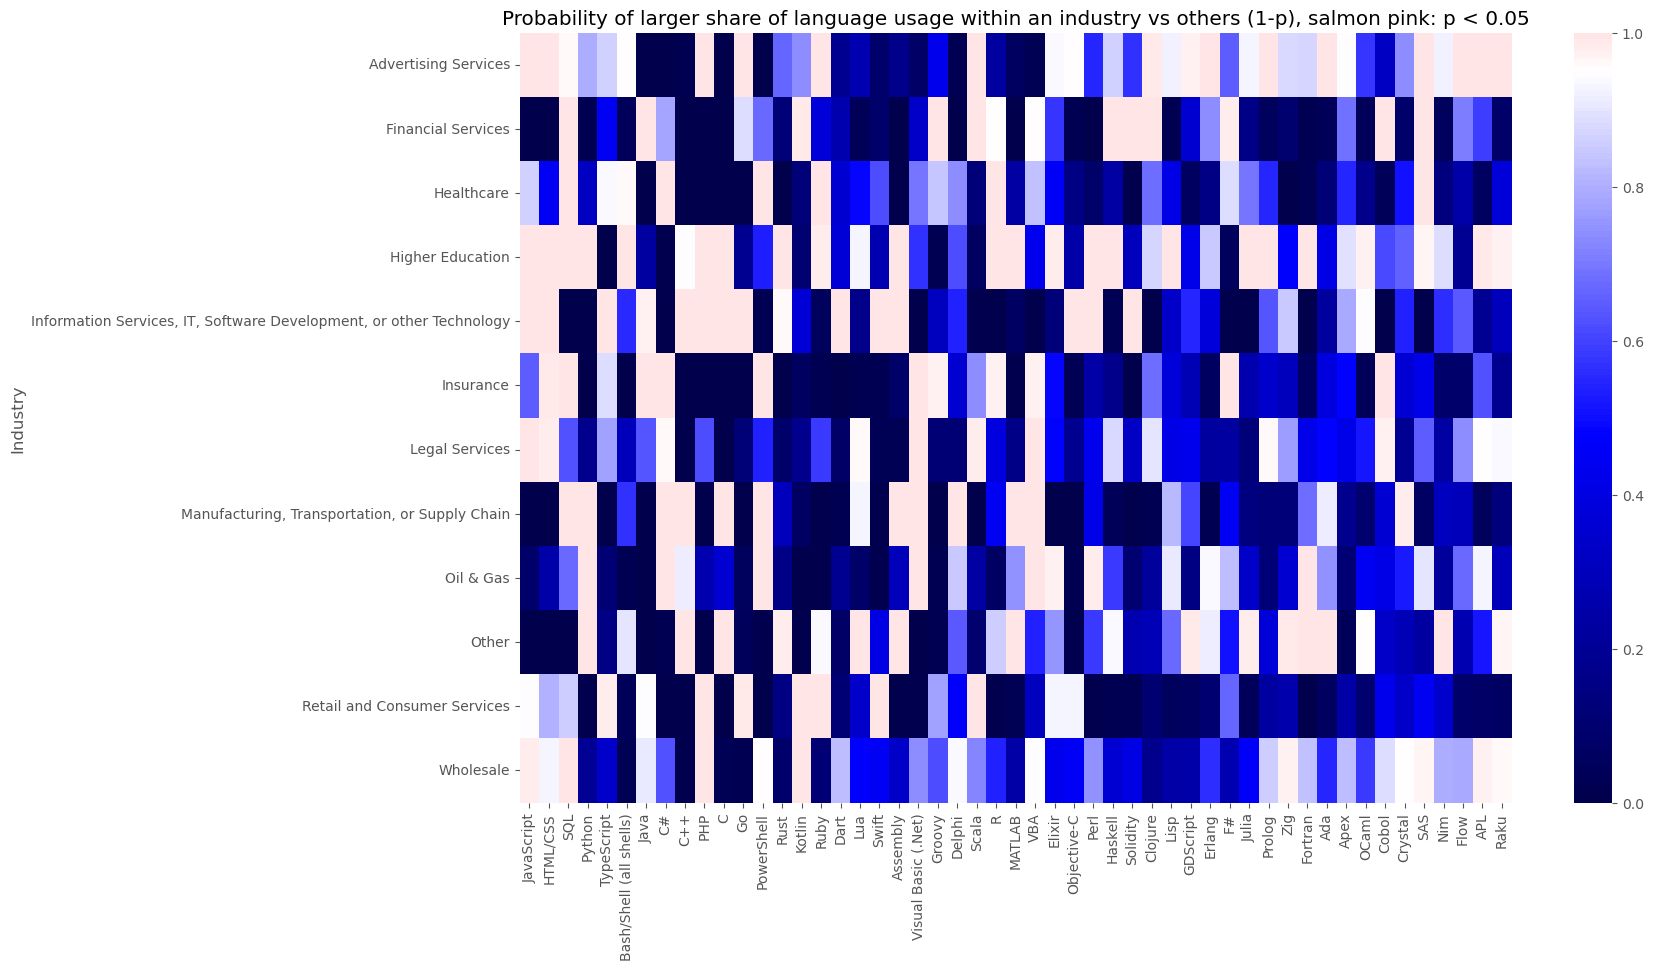

In [29]:
_, ax = plt.subplots(figsize=(16,10))
ax.set_title('Probability of larger share of language usage within an industry vs others (1-p), salmon pink: p < 0.05')
sns.heatmap(1-prop_tests, ax=ax, center=0.95, cmap='seismic')

<Axes: title={'center': 'Z-test statistic for share of language usage within an industry vs others'}, ylabel='Industry'>

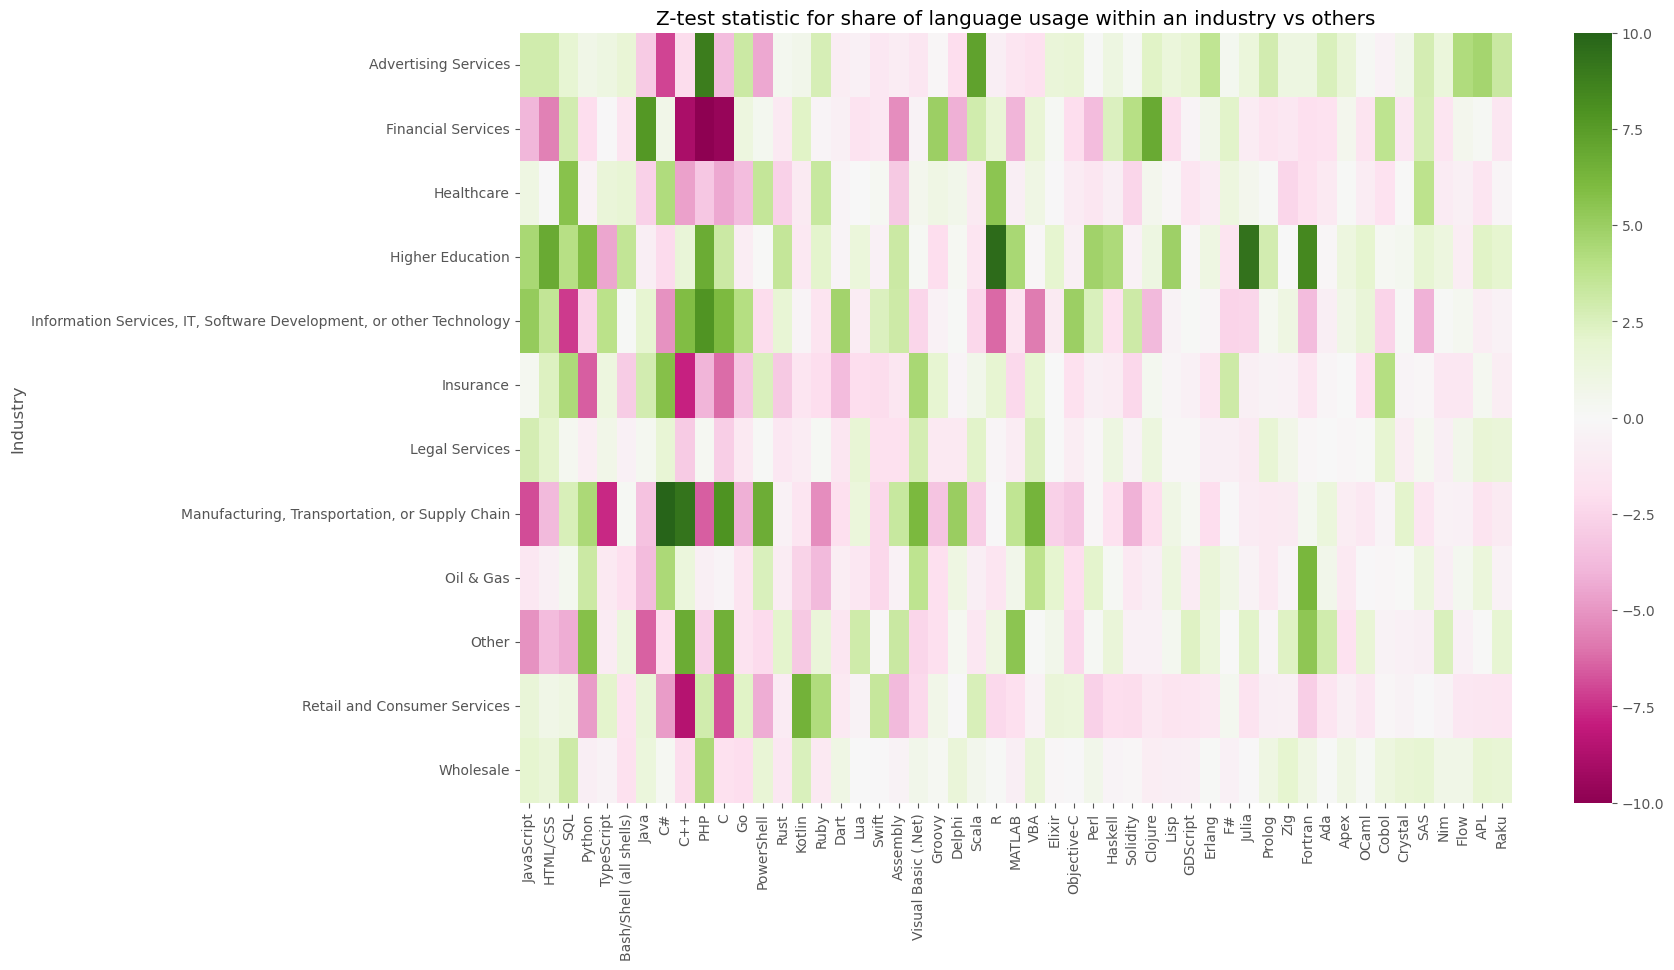

In [30]:
_, ax = plt.subplots(figsize=(16,10))
ax.set_title('Z-test statistic for share of language usage within an industry vs others')
sns.heatmap(z_tests, ax=ax, center=0, cmap='PiYG', vmin=-10, vmax=10)

<Axes: title={'center': 'Z-score for share of language usage in Information Services, IT, Software Development, or other Technology vs other industries'}>

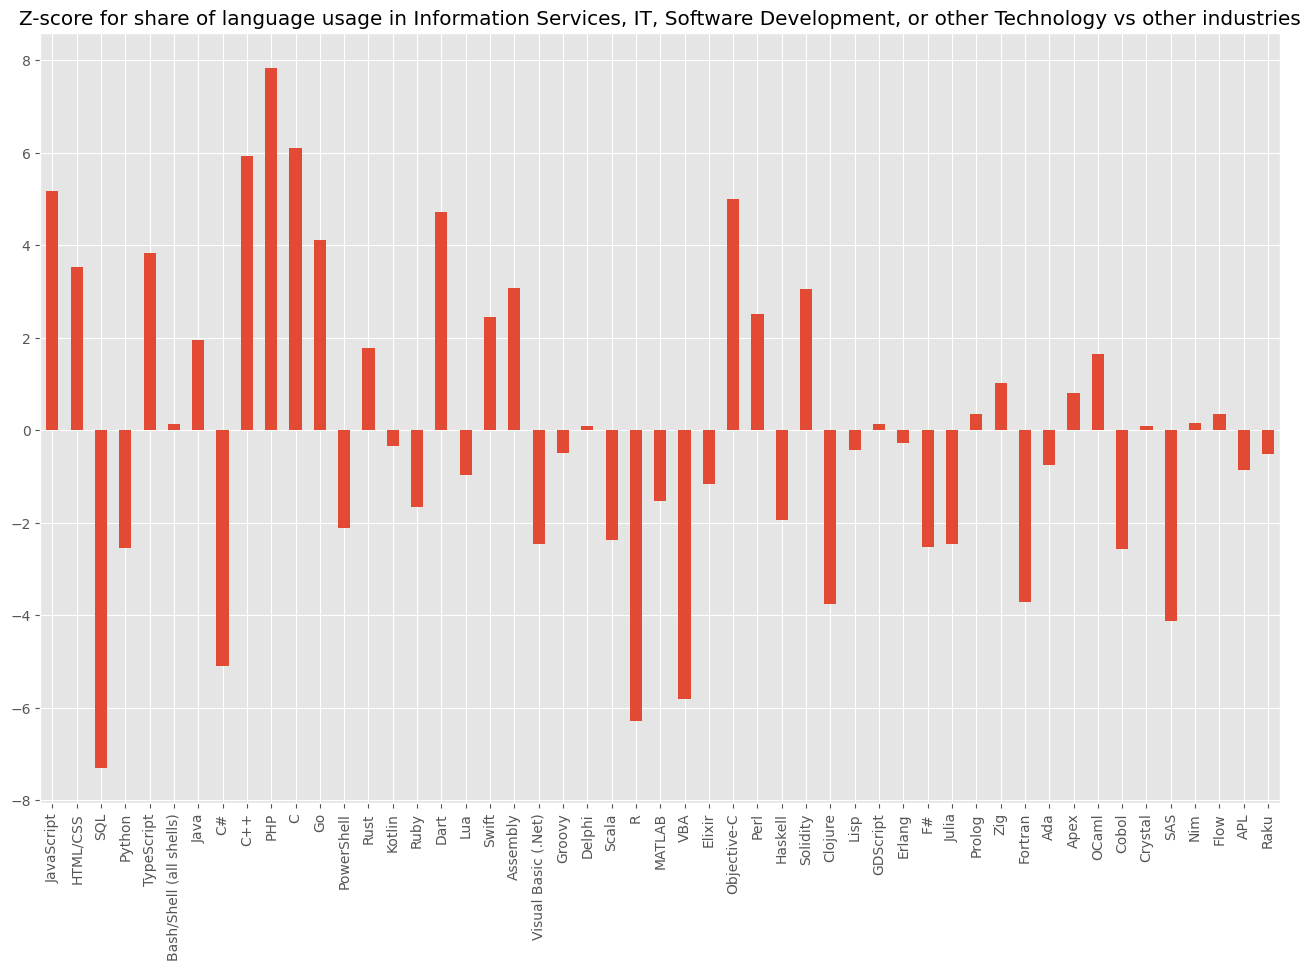

In [31]:
_, ax = plt.subplots(figsize=(16,10))
ax.set_title('Z-score for share of language usage in Information Services, IT, Software Development, or other Technology vs other industries')
z_tests.loc['Information Services, IT, Software Development, or other Technology'].plot.bar(ax=ax)

<Axes: title={'center': 'Difference in share of language usage within an industry vs others'}, ylabel='Industry'>

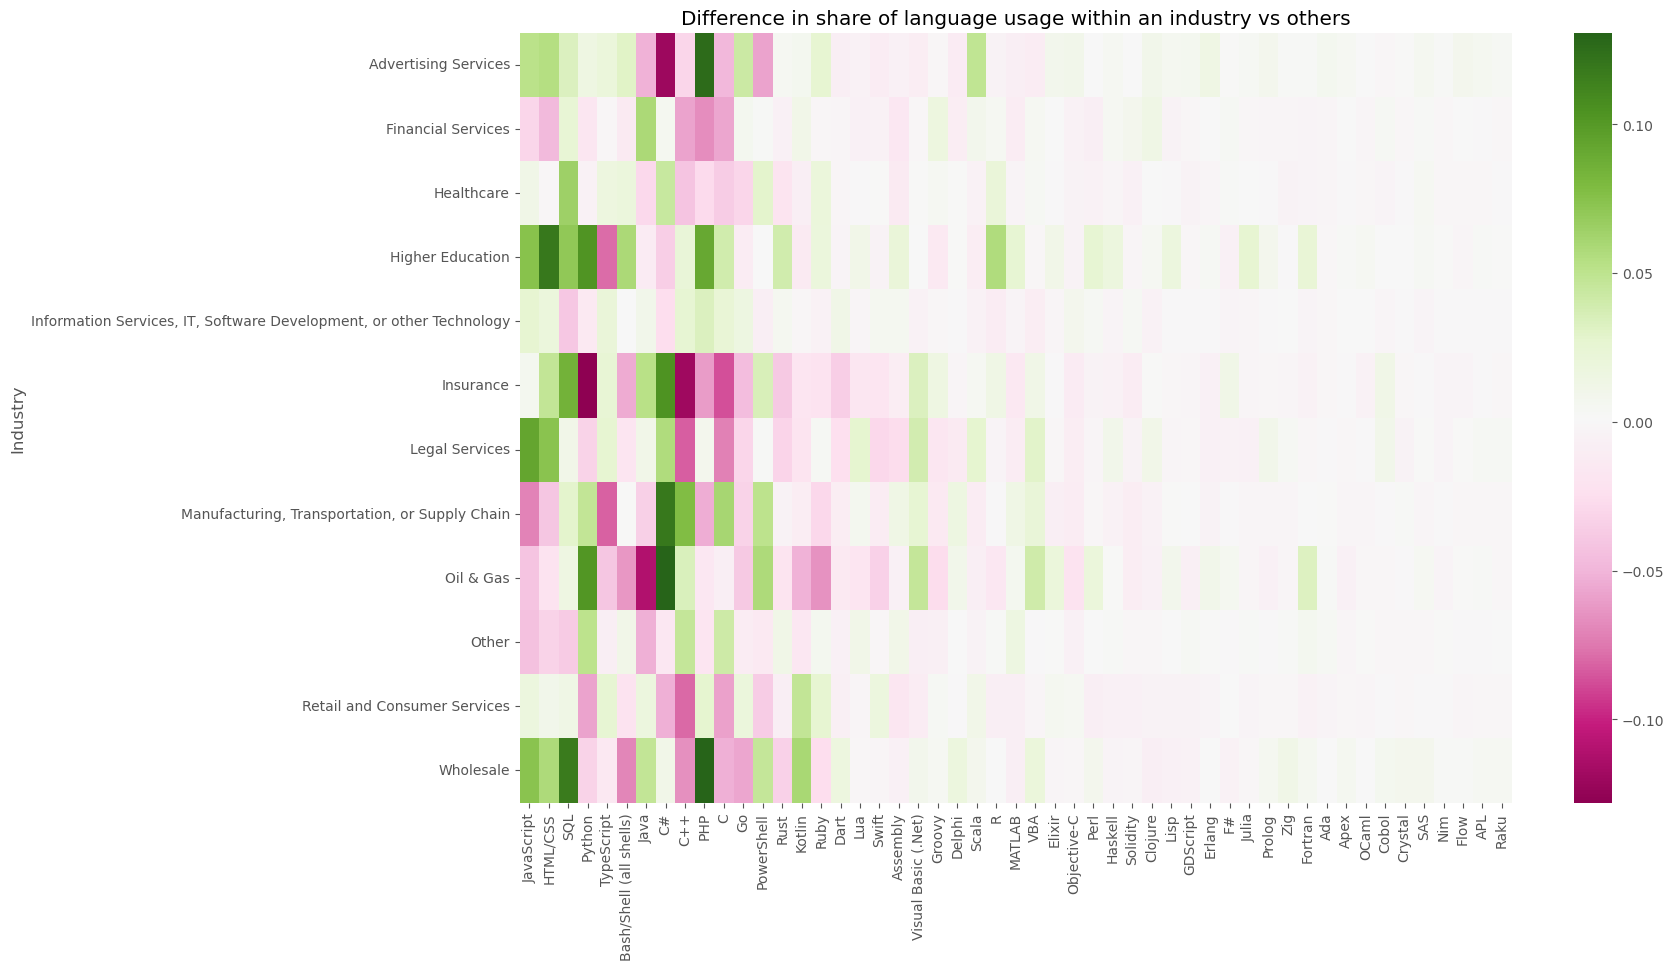

In [32]:
_, ax = plt.subplots(figsize=(16,10))
ax.set_title('Difference in share of language usage within an industry vs others')
sns.heatmap(prop_diffs, ax=ax, cmap='PiYG')

<Axes: title={'center': 'Difference in share of language usage in Information Services, IT, Software Development, or other Technology vs other industries'}>

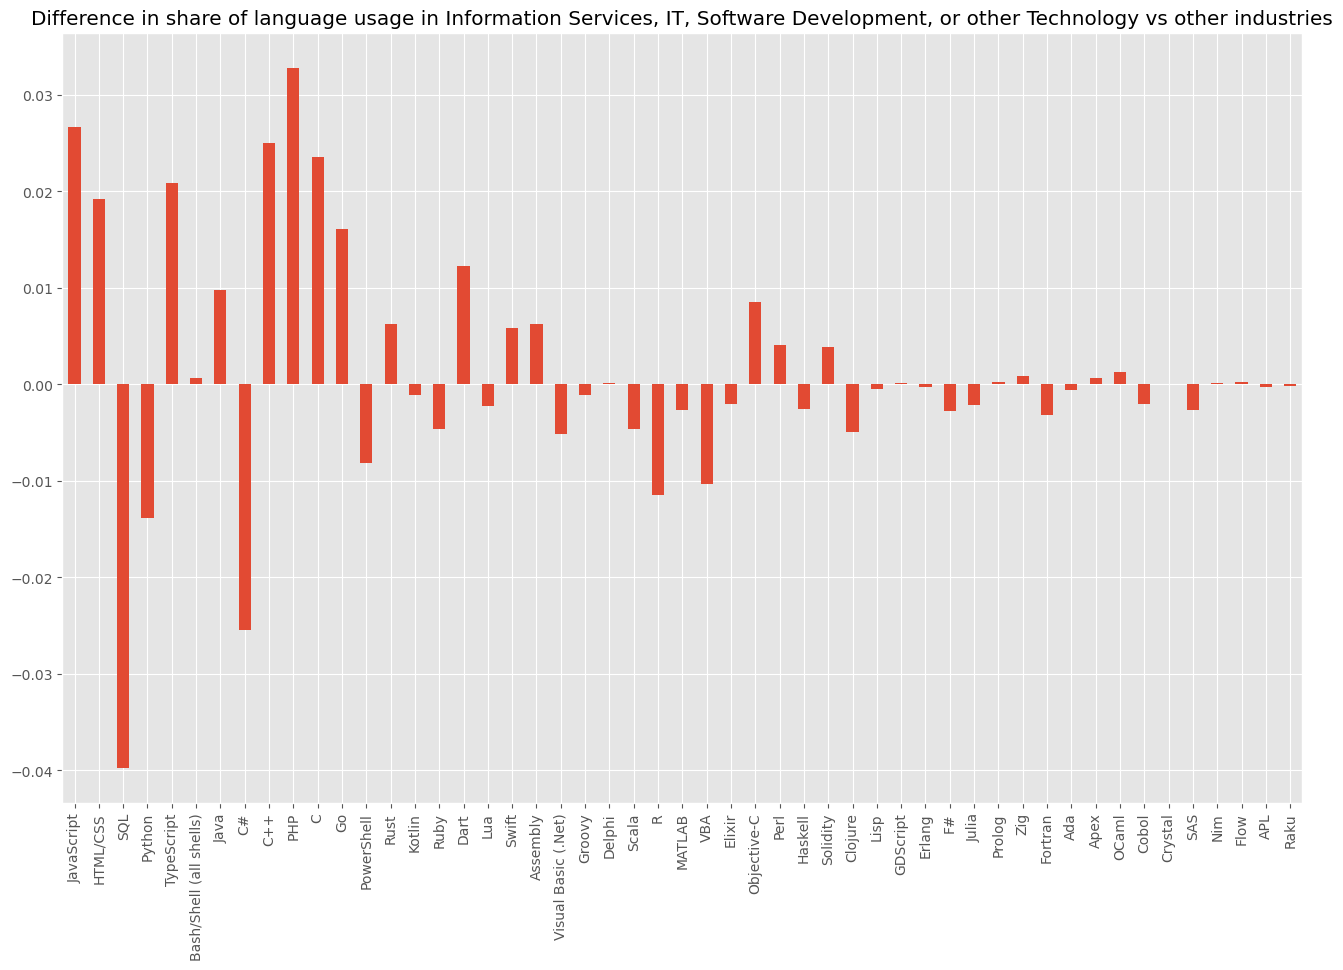

In [33]:
_, ax = plt.subplots(figsize=(16,10))
ax.set_title('Difference in share of language usage in Information Services, IT, Software Development, or other Technology vs other industries')
prop_diffs.loc['Information Services, IT, Software Development, or other Technology'].plot.bar(ax=ax)

<Axes: title={'center': 'Proportion of respondents who work with Python'}, xlabel='Industry'>

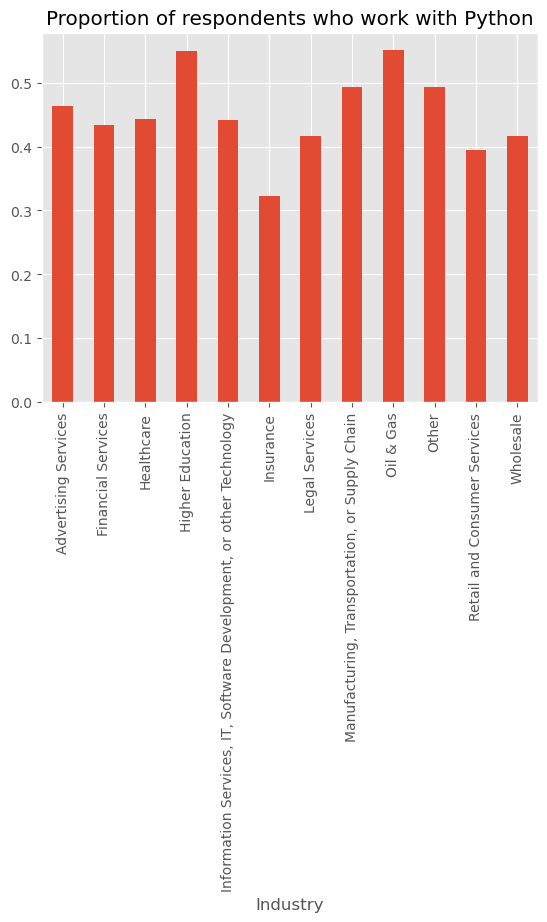

In [34]:
df_languages_by_industry.groupby('Industry').mean()['Python'].plot.bar(title='Proportion of respondents who work with Python')

## Related Languages

### Languages worked with this year
- Let's try to find related/mutually worked with languages

<Axes: >

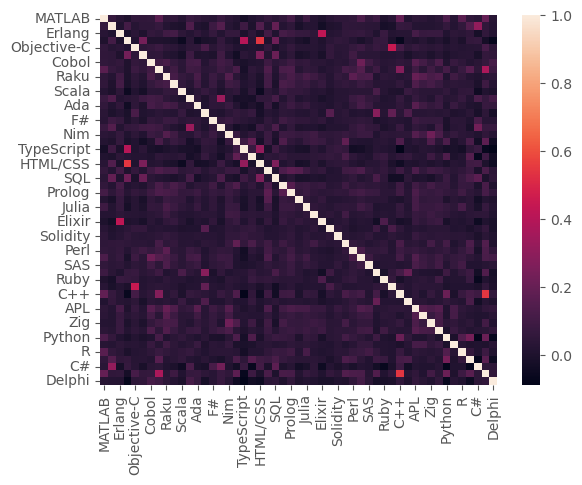

In [35]:
languages_corr = languages.corr()
sns.heatmap(languages_corr)

- Filter down to more correlated languages

<Axes: >

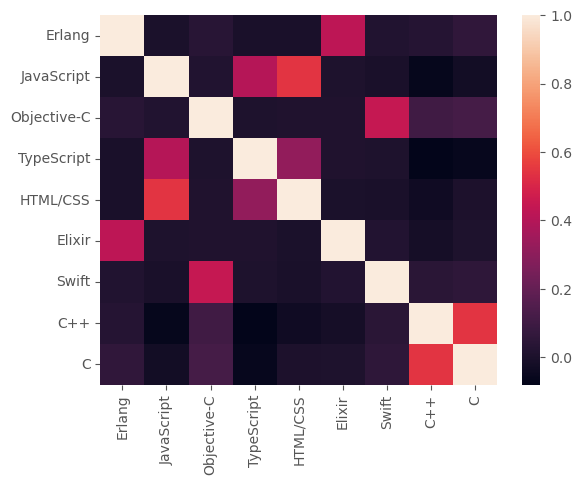

In [36]:
sns.heatmap(languages[((languages_corr.abs() > .4).sum() > 1).replace(False, pd.NA).dropna().index].corr())

<BarContainer object of 23 artists>

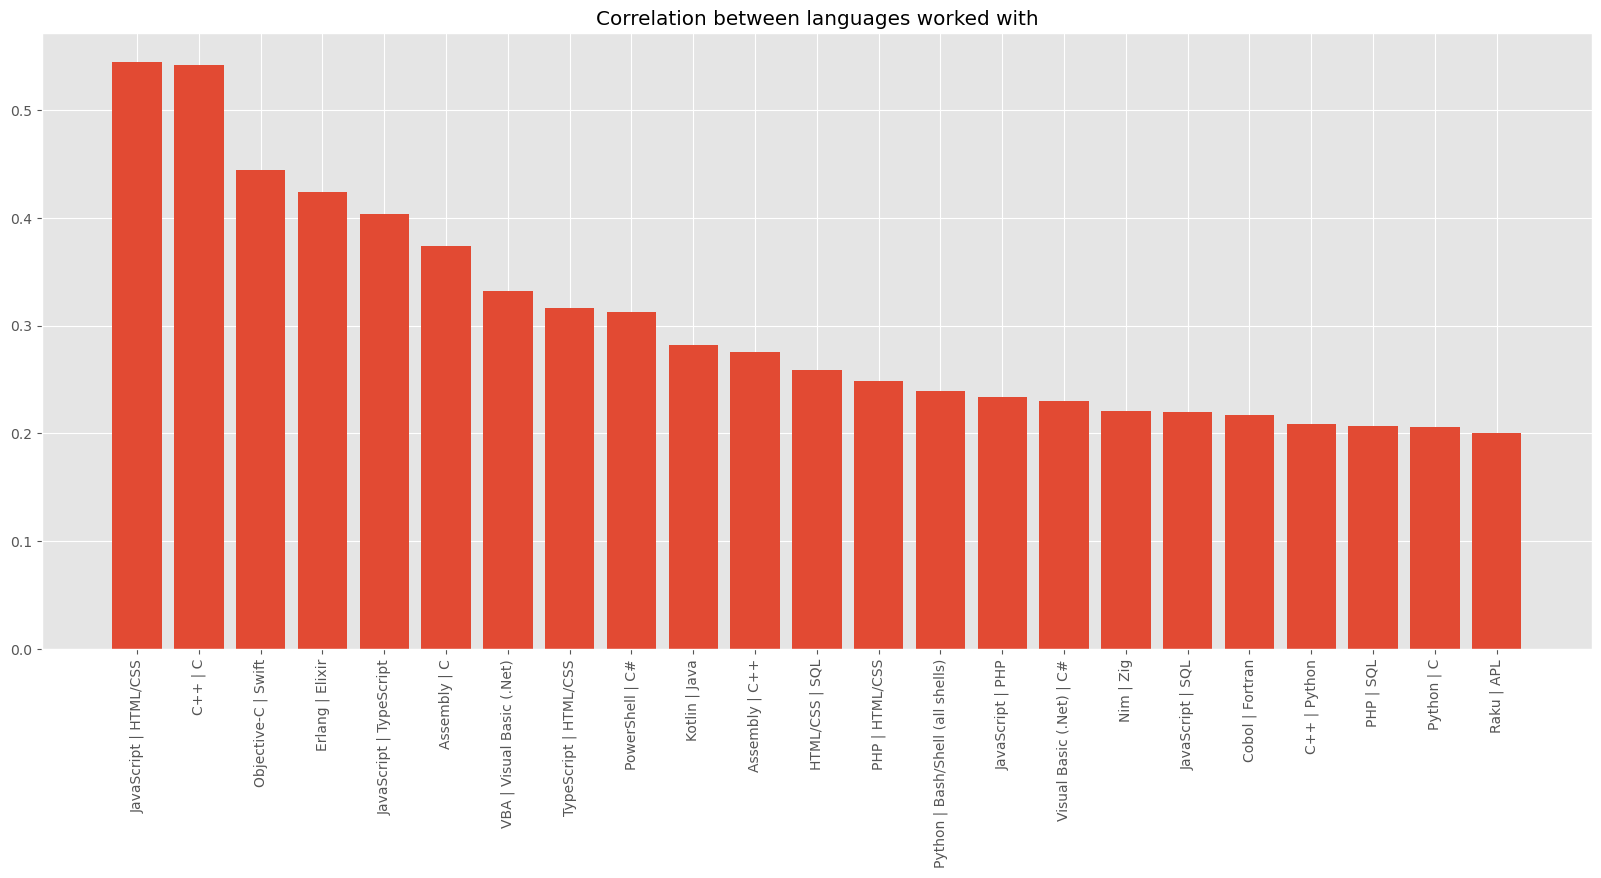

In [37]:
#Plot bar graph of correlations > 0.2
corrs = pd.Series()
for l1 in languages.columns:
    for l2 in languages.columns[languages.columns.get_loc(l1):]:
        if l1 != l2 and languages_corr[l1][l2] > 0.2:
            corrs[f'{l1} | {l2}'] = languages_corr[l1][l2]
corrs = corrs.sort_values(ascending=False)
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.title('Correlation between languages worked with')
plt.bar(corrs.index, corrs)

- As expected, JavsScript and HTML/CSS have the highest correlation. If you are going to be working with one, there's a good chance you will also need to work with the other.

0.23796138901099603


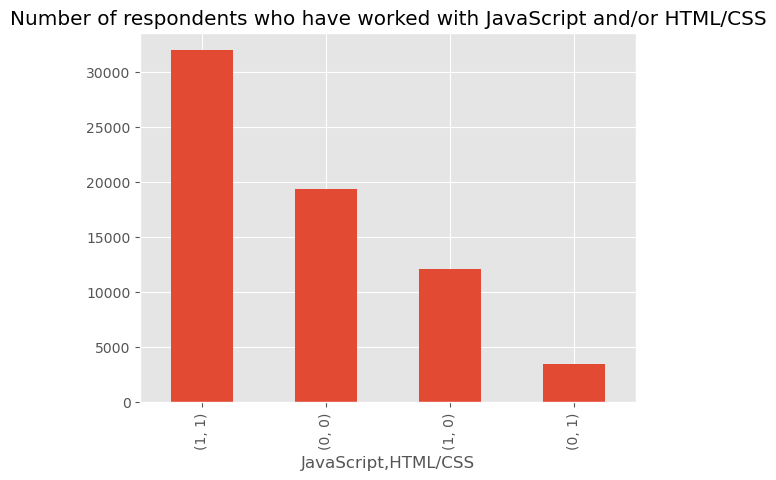

In [38]:
languages[['JavaScript', 'HTML/CSS']].value_counts().plot.bar(title='Number of respondents who have worked with JavaScript and/or HTML/CSS')
print(normalized_mutual_info_score(languages['JavaScript'], languages['HTML/CSS']))

0.2525719736968396


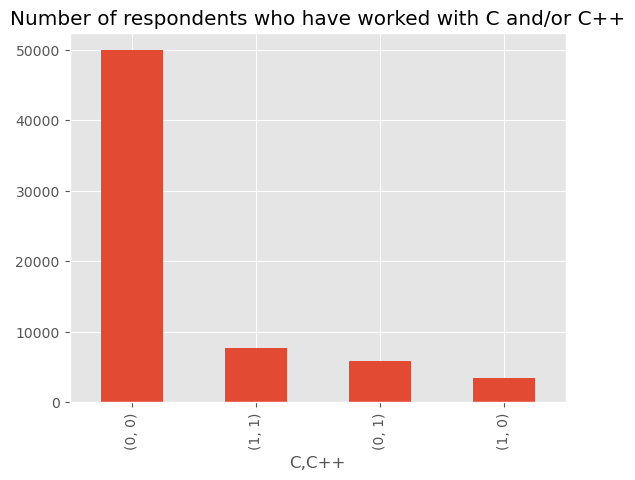

In [39]:
languages[['C', 'C++']].value_counts().plot.bar(title='Number of respondents who have worked with C and/or C++')
print(normalized_mutual_info_score(languages['C'], languages['C++']))

<Axes: title={'center': 'Number of respondents who have worked with JavaScript and/or TypeScript'}, xlabel='JavaScript,TypeScript'>

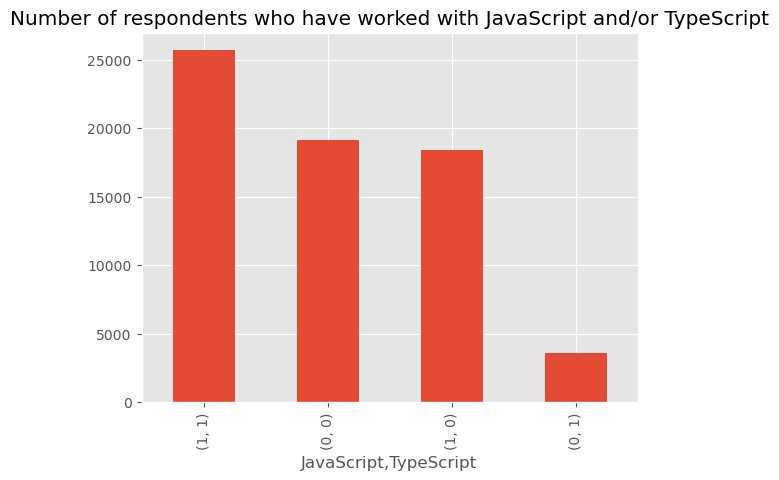

In [40]:
languages[['JavaScript', 'TypeScript']].value_counts().plot.bar(title='Number of respondents who have worked with JavaScript and/or TypeScript')

### Adding in languages to work on for next year

In [41]:
languages_next.sum().sort_values(ascending=False)

JavaScript                 27039
TypeScript                 26569
Python                     24371
SQL                        23477
HTML/CSS                   22709
Rust                       20479
C#                         14770
Go                         14590
Bash/Shell (all shells)    13653
Java                       10761
C++                         9165
Kotlin                      8242
C                           6147
PHP                         5944
Dart                        4542
PowerShell                  4460
Swift                       4174
Ruby                        3371
Elixir                      3255
Lua                         2576
Zig                         2574
Scala                       2347
Haskell                     2290
Assembly                    2098
F#                          1727
R                           1652
Clojure                     1508
Delphi                      1447
Julia                       1242
Solidity                    1218
Erlang    

<Axes: >

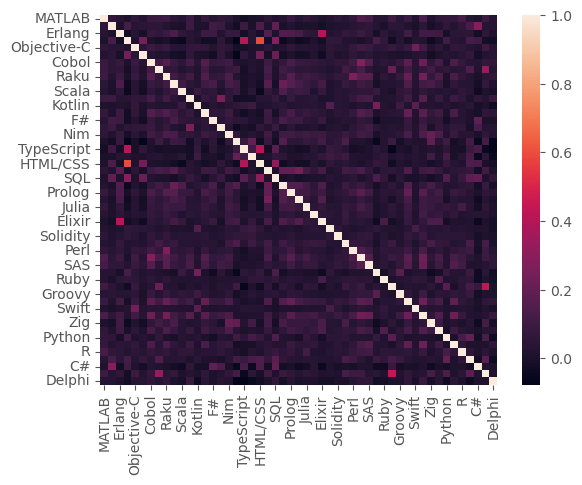

In [42]:
languages_next_corr = languages_next.corr()
sns.heatmap(languages_next_corr)

<Axes: >

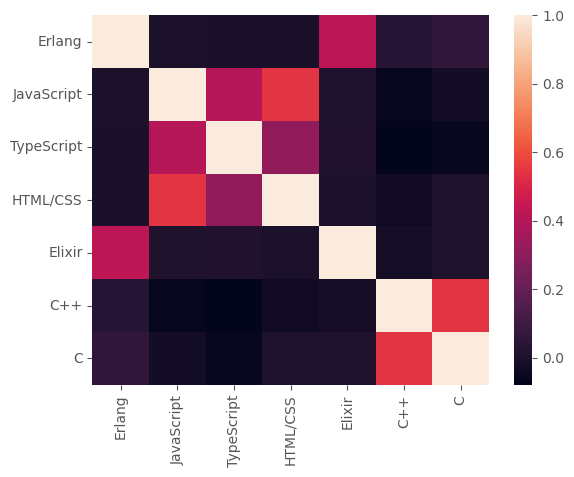

In [43]:
sns.heatmap(languages[((languages_next_corr.abs() > .4).sum() > 1).replace(False, pd.NA).dropna().index].corr())

<BarContainer object of 32 artists>

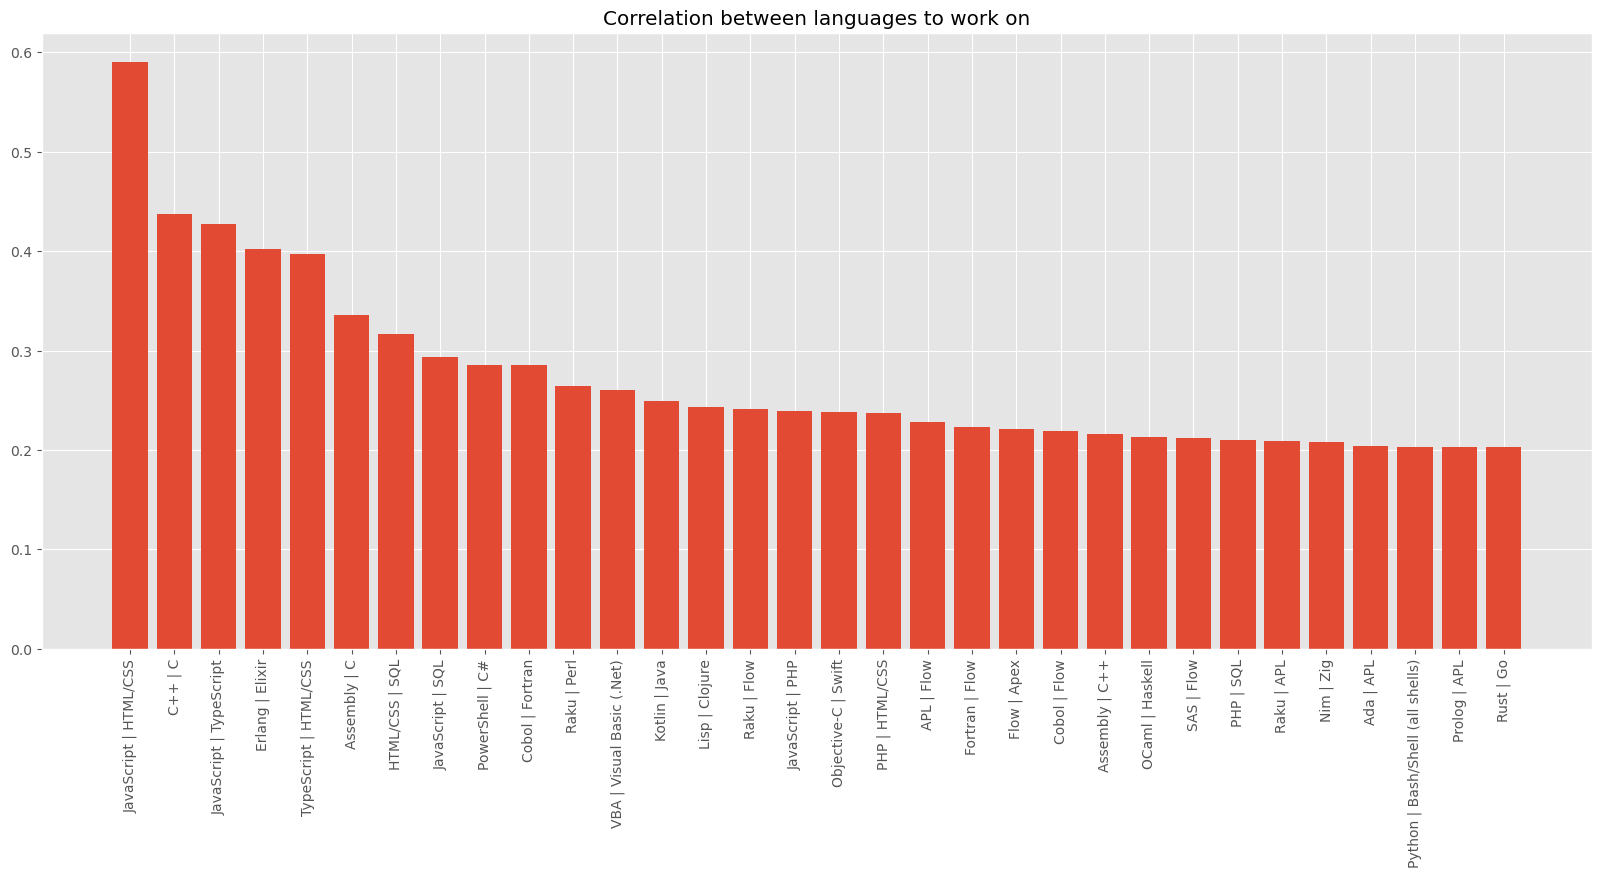

In [44]:
#Plot bar graph of correlations > 0.2
corrs = pd.Series()
for l1 in languages.columns:
    for l2 in languages.columns[languages.columns.get_loc(l1):]:
        if l1 != l2 and languages_next_corr[l1][l2] > 0.2:
            corrs[f'{l1} | {l2}'] = languages_next_corr[l1][l2]
corrs = corrs.sort_values(ascending=False)
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.title('Correlation between languages to work on')
plt.bar(corrs.index, corrs)

<BarContainer object of 16 artists>

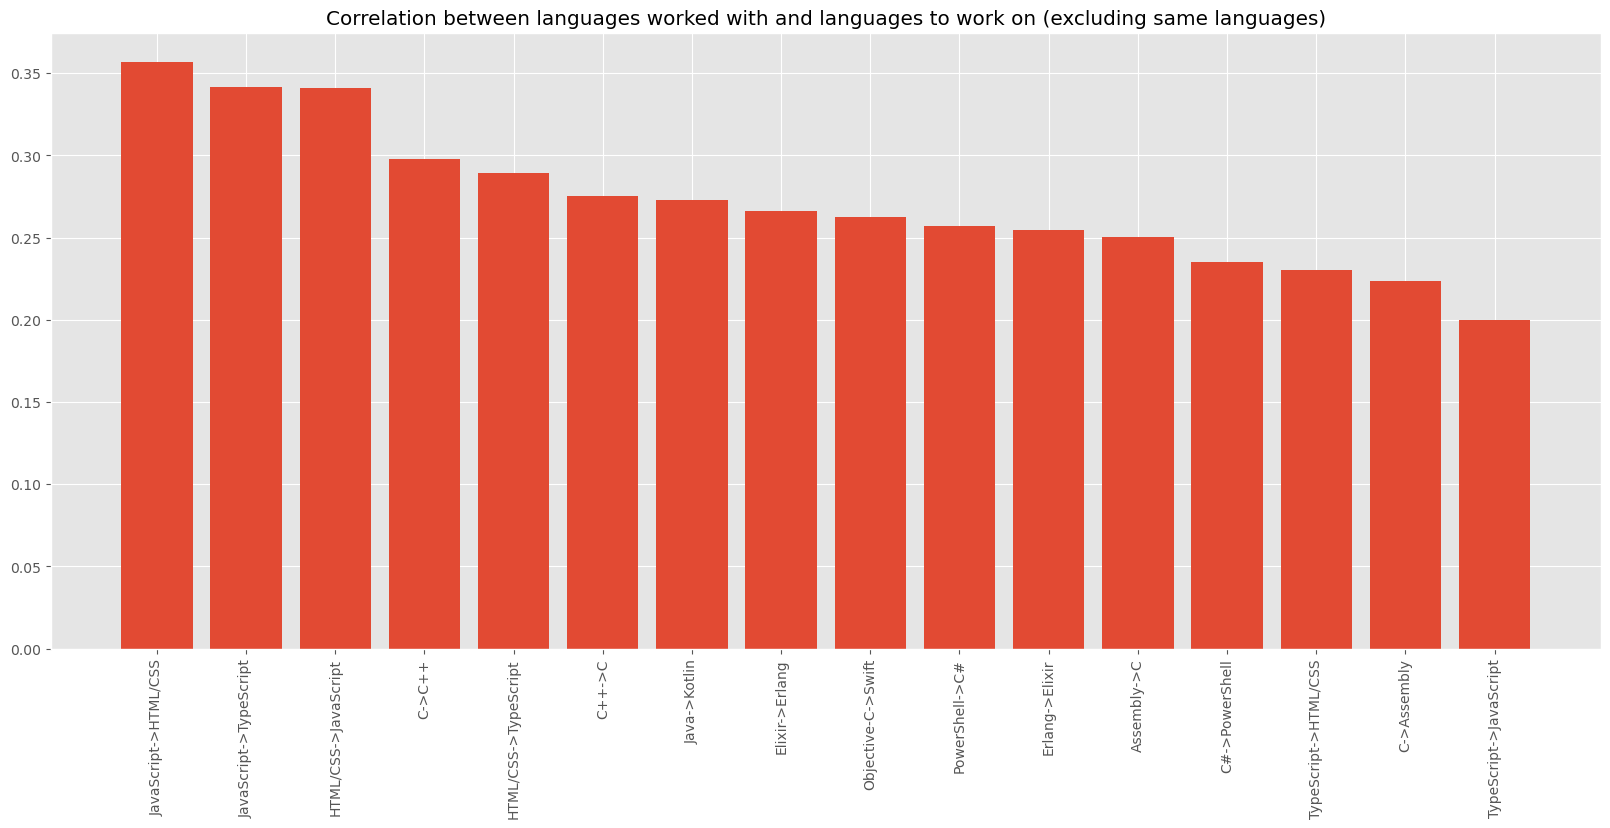

In [45]:
#Plot bar graph of correlations > 0.2
corrs = pd.Series()
for l1 in languages.columns:
    for l2 in languages_next.columns:
        corr = np.corrcoef(languages[l1], languages_next[l2])[0][1]
        if l1 != l2 and corr > 0.2:
            corrs[f'{l1}->{l2}'] = corr
corrs = corrs.sort_values(ascending=False)
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.title('Correlation between languages worked with and languages to work on (excluding same languages)')
plt.bar(corrs.index, corrs)